In [41]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split

df = pd.read_csv('ml-1m/ratings.dat', 
                 sep="::", engine='python', usecols=[0, 1, 2], names=['UserID', 'MovieID', 'rating'])
df['UserID'] = df.UserID.astype('int32')
df['MovieID'] = df.MovieID.astype('int32')
df.head()

,UserID,MovieID,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [2]:
user_items = df[['UserID', 'MovieID']].values
ratings = df.rating.values
n_users = len(df.UserID.unique())
n_movies = len(df.MovieID.unique())
print(n_users, n_movies)
# mapping for users
user_lookup = {v: i for i, v in enumerate(df.UserID.unique())}
# mapping for movies
movie_lookup = {v: i for i, v in enumerate(df.MovieID.unique())}

6040 3706


In [3]:
X_train, X_test, y_train, y_test = train_test_split(user_items, ratings, test_size=0.4)

user_train, movie_train = map(list, zip(*X_train))
user_test, movie_test = map(list, zip(*X_test))
train_df = pd.DataFrame({"UserID": user_train, "MovieID": movie_train, "rating": y_train})
test_df = pd.DataFrame({"UserID": user_test, "MovieID": movie_test, "rating": y_test})

In [4]:
from torch.utils.data import Dataset

class UserItemRatingsDataset(Dataset):
    def __init__(self, df, user_lookup, movie_lookup):
        self.df = df
        self.user_lookup = user_lookup
        self.movie_lookup = movie_lookup
    
    def __getitem__(self, index):

        rating = torch.tensor(self.df.rating.iloc[index]).float()
        return (self.user_lookup[self.df.UserID.iloc[index]], self.movie_lookup[self.df.MovieID.iloc[index]]), rating
    
    def __len__(self):
        return len(self.df)

training_set = UserItemRatingsDataset(train_df, user_lookup, movie_lookup)
test_set = UserItemRatingsDataset(test_df, user_lookup, movie_lookup)

In [5]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
class Generalized_Matrix_Factorization(torch.nn.Module):
    def __init__(self, num_users, num_items, factor_num=10):
        super(Generalized_Matrix_Factorization, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = factor_num
        self.float()

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users+1, embedding_dim=self.factor_num)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items+1, embedding_dim=self.factor_num)


    def forward(self, inputs):
        (user_indices, item_indices) = inputs
        dot = self.embedding_user(user_indices) * self.embedding_item(item_indices)
        return dot.sum(1)

    def init_weight(self):
        pass
    
model1 = Generalized_Matrix_Factorization(n_users, n_movies, 15).cuda()
# model2 = Generalized_Matrix_Factorization(n_users, n_movies, 10).cuda()

In [6]:
from torch.utils.data import DataLoader
training_load = DataLoader(training_set, batch_size=64, shuffle=True)
testing_load = DataLoader(test_set, batch_size=64, shuffle=True)
cuda = torch.cuda.device('cuda')

In [7]:
from tqdm import tqdm
def fit1(iterator, model, optimizer, criterion):
    train_loss = 0
    model.train()
    with tqdm(iterator, unit="batch") as tepoch:
        for x, y in tepoch:
            x[0] = x[0].cuda()
            x[1] = x[1].cuda()
            y = y.cuda()
            optimizer.zero_grad()
            y_hat = model(x)
            loss = loss_func(y, y_hat)
            loss += 1e-6*torch.sum(model.embedding_user.weight**2)
            loss += 1e-6*torch.sum(model.embedding_item.weight**2)
            train_loss += loss
            loss.backward()
            optimizer.step()
    return train_loss / len(iterator.dataset)

def test1(iterator, model, criterion):
    test_loss = 0
    model.eval()
    with tqdm(iterator, unit="batch") as tepoch:
        for x, y in tepoch:
            x[0] = x[0].cuda()
            x[1] = x[1].cuda()
            y = y.cuda()
            with torch.no_grad():
                y_hat = model(x)
            loss = loss_func(y, y_hat)
            # model weight regularization
            loss += 1e-6*torch.sum(model.embedding_user.weight**2)
            loss += 1e-6*torch.sum(model.embedding_item.weight**2)
            test_loss += loss
    return test_loss / len(iterator.dataset)

optimizer = torch.optim.Adam(model1.parameters(),
                            lr=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7, 15], gamma=0.1)
loss_func = torch.nn.MSELoss().cuda()
for i in range(1, 21):
    print(f"Epoch: {i}")
    training_loss = fit1(training_load, model1, optimizer, loss_func)
    testing_loss = test1(testing_load, model1, loss_func)
    print(f"Training Loss: {training_loss}\nTesting Loss: {testing_loss}")
    scheduler.step()
# optimizer = torch.optim.Adam(model2.parameters(),
#                             lr=1e-2)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7, 15], gamma=0.1)
# loss_func = torch.nn.MSELoss().cuda()
# for i in range(1, 21):
#     print(f"Epoch: {i}")
#     training_loss = fit1(training_load, model2, optimizer, loss_func)
#     testing_loss = test1(testing_load, model2, loss_func)
#     print(f"Training Loss: {training_loss}\nTesting Loss: {testing_loss}")
#     scheduler.step()

Epoch: 1


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:26<00:00, 236.01batch/s]


Training Loss: 0.07807575166225433
Testing Loss: 0.021290548145771027
Epoch: 2


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:26<00:00, 234.71batch/s]


Training Loss: 0.0198079664260149
Testing Loss: 0.0199086032807827
Epoch: 3


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:28<00:00, 219.40batch/s]


Training Loss: 0.018678979948163033
Testing Loss: 0.019486822187900543
Epoch: 4


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:26<00:00, 235.16batch/s]


Training Loss: 0.018306339159607887
Testing Loss: 0.019324788823723793
Epoch: 5


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:27<00:00, 229.48batch/s]


Training Loss: 0.018001312389969826
Testing Loss: 0.019027413800358772
Epoch: 6


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:26<00:00, 234.67batch/s]


Training Loss: 0.017689764499664307
Testing Loss: 0.01866166666150093
Epoch: 7


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:26<00:00, 234.88batch/s]


Training Loss: 0.017429830506443977
Testing Loss: 0.01841445453464985
Epoch: 8


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:26<00:00, 232.47batch/s]


Training Loss: 0.012763159349560738
Testing Loss: 0.013984108343720436
Epoch: 9


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:26<00:00, 233.02batch/s]


Training Loss: 0.010976911522448063
Testing Loss: 0.01364843174815178
Epoch: 10


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:26<00:00, 234.27batch/s]


Training Loss: 0.01042911782860756
Testing Loss: 0.013599715195596218
Epoch: 11


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:26<00:00, 234.91batch/s]


Training Loss: 0.010115792974829674
Testing Loss: 0.013647324405610561
Epoch: 12


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:26<00:00, 235.45batch/s]


Training Loss: 0.00991629809141159
Testing Loss: 0.013704209588468075
Epoch: 13


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:27<00:00, 230.97batch/s]


Training Loss: 0.009783992543816566
Testing Loss: 0.013774058781564236
Epoch: 14


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:25<00:00, 242.42batch/s]


Training Loss: 0.009685211814939976
Testing Loss: 0.013827524147927761
Epoch: 15


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:27<00:00, 230.88batch/s]


Training Loss: 0.00960994977504015
Testing Loss: 0.013883879408240318
Epoch: 16


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:28<00:00, 222.31batch/s]


Training Loss: 0.00890029314905405
Testing Loss: 0.01381942443549633
Epoch: 17


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:28<00:00, 222.67batch/s]


Training Loss: 0.008837771601974964
Testing Loss: 0.013816121965646744
Epoch: 18


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:27<00:00, 223.49batch/s]


Training Loss: 0.00881060492247343
Testing Loss: 0.0138244004920125
Epoch: 19


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:26<00:00, 232.93batch/s]


Training Loss: 0.008795155212283134
Testing Loss: 0.013839904218912125
Epoch: 20


100%|█████████████████████████████████████████████████████████████| 6252/6252 [00:26<00:00, 232.35batch/s]

Training Loss: 0.008783443830907345
Testing Loss: 0.013852670788764954


In [36]:
def NDCG(rel_pos):
    '''
    Parameter: rel_pos: 3d-array with dimension (n_users, n_instance, n_rel)
    '''
    n_instance = rel_pos.shape[1]
    n_rel = rel_pos.shape[2]
    ndcg = np.sum(1/np.log2(rel_pos+1), axis=2)
    ndcg /= sum(1/(np.log2(np.arange(1, n_rel+1)+1)))
    ndcg = np.sum(ndcg, axis=1)/n_instance
    
    return ndcg

# method to correct the relevant item position
def correct_pos(rel_pos, n, m):
    return np.floor(1+((n-1)*(rel_pos-1)/(m)))

# method to get the ranking of relevant item
def get_rel_pos(scores, rel_scores, correct=False, n=0, m=0):
    pos = np.array([sum(scores > x)+1 for x in rel_scores])
    if correct:
        pos = correct_pos(pos, n, m)
    return pos


In [11]:
unique_users = df.UserID.unique().flatten() # Get unique user ID for iteration
mapped_df = df.copy()
vectorized_lookup = np.vectorize(movie_lookup.get)
mapped_df['MovieID'] = mapped_df.MovieID.apply(vectorized_lookup) # Apply the movieID mapping 
unique_movies = mapped_df.MovieID.unique() # List of unique movie ID

In [34]:
def ranking(n_rel=1, n_samples=None, metric=NDCG, n_instance=5, df=mapped_df, model=model1, correct=False):
    ndcgs = []
    grouped_df = df.groupby('UserID')
    ranking_positions = np.zeros((grouped_df.ngroups, n_instance, n_rel))
    # Loop through the users
    for i, (userID, user_df) in enumerate(tqdm(grouped_df, total=grouped_df.ngroups, unit='users')):
        
        # get the type of ratings
        orig_rel_ratings = user_df[user_df.rating >= 2.5].rating.to_numpy()
        orig_irrel_ratings = user_df[user_df.rating < 2.5].rating.to_numpy()
        
        # get all unrated movies for a user
        all_irrels = np.setdiff1d(unique_movies, user_df.MovieID, assume_unique=True)
        
        for j in range(n_instance):
            
            rel_ratings = orig_rel_ratings.copy()
            
            # sample from some irrelevant rated items if the relevant rated items do not have enough items
            if(n_rel > len(orig_rel_ratings)):
                rel_ratings = np.append(orig_rel_ratings, np.random.choice(orig_irrel_ratings, n_rel-len(rel_ratings)))
            
            # if we are sampling
            if n_samples is not None:
                movies = np.random.choice(all_irrels, n_samples)
            else:
                movies = all_irrels
            
            sets = [np.array([user_lookup[userID]]*len(movies)), movies]
            sets = (torch.LongTensor(sets[0]).cuda(), torch.LongTensor(sets[1]).cuda())
            
            # predict the ratings
            with torch.no_grad():
                scores = model(sets).to('cpu').numpy()
            
            chosen_ratings = np.random.choice(rel_ratings, n_rel)
            ranking_positions[i, j, :] = get_rel_pos(scores, chosen_ratings, correct=correct, n=len(all_irrels)+n_rel, m=n_samples)
    ndcgs = metric(ranking_positions)
    return ndcgs

Ranking Exact Rankings


100%|██████████████████████████████████████████████████████████████| 6040/6040 [03:49<00:00, 26.27users/s]



Ranking with 1 sampled items


100%|█████████████████████████████████████████████████████████████| 6040/6040 [00:21<00:00, 283.30users/s]



Ranking with 10 sampled items


100%|█████████████████████████████████████████████████████████████| 6040/6040 [00:21<00:00, 285.83users/s]



Ranking with 40 sampled items


100%|█████████████████████████████████████████████████████████████| 6040/6040 [00:19<00:00, 306.96users/s]



Ranking with 100 sampled items


100%|█████████████████████████████████████████████████████████████| 6040/6040 [00:25<00:00, 234.19users/s]



Ranking with 400 sampled items


100%|█████████████████████████████████████████████████████████████| 6040/6040 [00:44<00:00, 135.13users/s]



Ranking with 1000 sampled items


100%|██████████████████████████████████████████████████████████████| 6040/6040 [01:22<00:00, 73.35users/s]


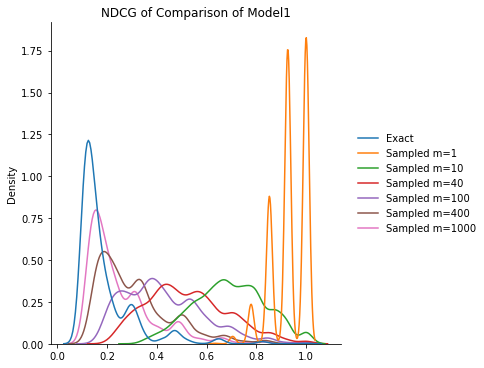

In [35]:
# plotting distribution for uncorrected 1 relevant item
ndcg_df = pd.DataFrame()
print("Ranking Exact Rankings")
ndcg_df["Exact"] = ranking(model=model1)
print()
for i in [1, 10, 40, 100, 400, 1000]:
    print(f"Ranking with {i} sampled items")
    ndcg_df[f"Sampled m={i}"] = ranking(n_samples=i, model=model1)
    print()
sns.displot(ndcg_df, kind='kde').set(title="NDCG of Comparison of Model1")

Ranking Exact Rankings


100%|██████████████████████████████████████████████████████████████| 6040/6040 [15:26<00:00,  6.52users/s]



Ranking with 1 sampled items


100%|█████████████████████████████████████████████████████████████| 6040/6040 [00:17<00:00, 355.17users/s]



Ranking with 10 sampled items


100%|█████████████████████████████████████████████████████████████| 6040/6040 [00:20<00:00, 296.47users/s]



Ranking with 40 sampled items


100%|█████████████████████████████████████████████████████████████| 6040/6040 [00:27<00:00, 218.98users/s]



Ranking with 100 sampled items


100%|█████████████████████████████████████████████████████████████| 6040/6040 [00:44<00:00, 134.24users/s]



Ranking with 400 sampled items


100%|██████████████████████████████████████████████████████████████| 6040/6040 [02:20<00:00, 42.85users/s]



Ranking with 1000 sampled items


100%|██████████████████████████████████████████████████████████████| 6040/6040 [04:55<00:00, 20.41users/s]


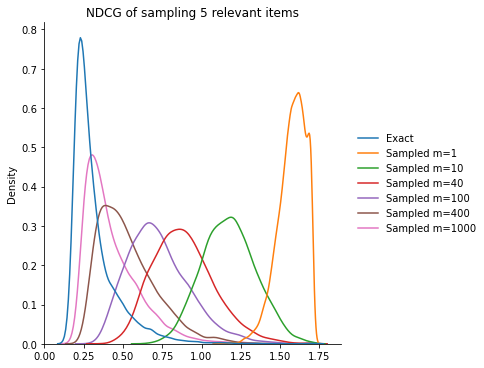

In [30]:
# plotting distribution for uncorrected 5 relevant items
ndcg_df = pd.DataFrame()
print("Ranking Exact Rankings")
ndcg_df["Exact"] = ranking(n_rel=5)
print()
# n_ranking = len(ndcg_df["Exact"])
for i in [1, 10, 40, 100, 400, 1000]:
    print(f"Ranking with {i} sampled items")
#     ndcgs = np.pad(ndcgs, mode='constant')
    ndcg_df[f"Sampled m={i}"] = ranking(n_rel=5, n_samples=i)
    print()
sns.displot(ndcg_df, kind='kde').set(title="NDCG of sampling 5 relevant items")

In [45]:
# read in user information
users_df = pd.read_csv('ml-1m/users.dat', 
                 sep="::", engine='python', names='UserID::Gender::Age::Occupation::Zip-code'.split('::'))

In [46]:
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


Ranking F
Ranking Exact Rankings


100%|██████████████████████████████████████████████████████████████| 1709/1709 [01:13<00:00, 23.35users/s]


Ranking M
Ranking Exact Rankings


100%|██████████████████████████████████████████████████████████████| 4331/4331 [03:07<00:00, 23.04users/s]


Ranking with 1 sampled items on F


100%|█████████████████████████████████████████████████████████████| 1709/1709 [00:06<00:00, 270.02users/s]



Ranking with 1 sampled items on M


100%|█████████████████████████████████████████████████████████████| 4331/4331 [00:15<00:00, 279.28users/s]



Ranking with 10 sampled items on F


100%|█████████████████████████████████████████████████████████████| 1709/1709 [00:05<00:00, 288.33users/s]



Ranking with 10 sampled items on M


100%|█████████████████████████████████████████████████████████████| 4331/4331 [00:15<00:00, 285.39users/s]



Ranking with 100 sampled items on F


100%|█████████████████████████████████████████████████████████████| 1709/1709 [00:08<00:00, 201.49users/s]



Ranking with 100 sampled items on M


100%|█████████████████████████████████████████████████████████████| 4331/4331 [00:21<00:00, 205.07users/s]



Ranking with 400 sampled items on F


100%|█████████████████████████████████████████████████████████████| 1709/1709 [00:14<00:00, 120.21users/s]



Ranking with 400 sampled items on M


100%|█████████████████████████████████████████████████████████████| 4331/4331 [00:37<00:00, 116.98users/s]



Ranking with 1000 sampled items on F


100%|██████████████████████████████████████████████████████████████| 1709/1709 [00:25<00:00, 67.32users/s]



Ranking with 1000 sampled items on M


100%|██████████████████████████████████████████████████████████████| 4331/4331 [01:04<00:00, 66.68users/s]


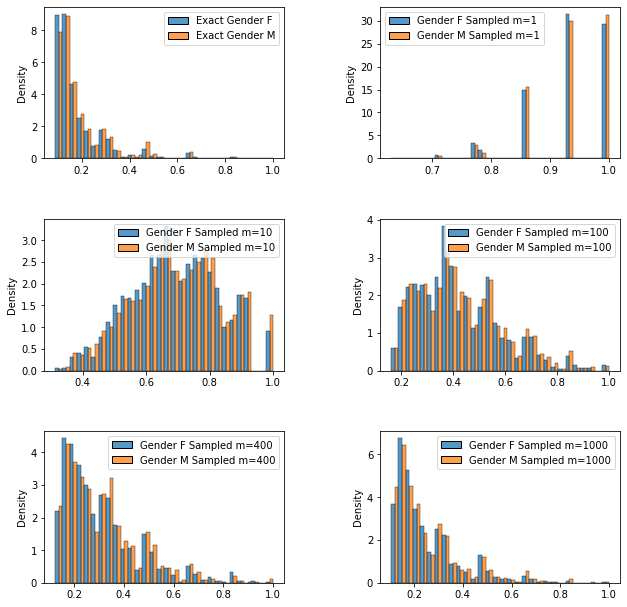

In [48]:
# plot distribution for uncorrected gender
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
ndcgs = []
ndcg_df = pd.DataFrame()

for group_name, df_group in users_df.groupby('Gender'):
    ndcgs = []
    print(f"Ranking {group_name}")
    print("Ranking Exact Rankings")
    user_df = mapped_df.loc[np.in1d(mapped_df.UserID, df_group.UserID), :]
    ndcg_df= pd.concat([ndcg_df, pd.DataFrame({f"Exact Gender {group_name}": ranking(df=user_df)})], axis=1)
row = 0
col = 0
sns.histplot(ndcg_df, stat='density', bins=30, common_norm=False, multiple='dodge', ax=ax[row, col])
col = 1
for i in [1, 10, 100, 400, 1000]:
    ndcg_df = pd.DataFrame()
    for group_name, df_group in users_df.groupby('Gender'):
        print(f"Ranking with {i} sampled items on {group_name}")
#     ndcgs = np.pad(ndcgs, mode='constant')
        user_df = mapped_df.loc[np.in1d(mapped_df.UserID, df_group.UserID), :]
        ndcg_df = pd.concat([ndcg_df, pd.DataFrame({f"Gender {group_name} Sampled m={i}": ranking(n_samples=i, df=user_df)})], axis=1)
        print()
    sns.histplot(ndcg_df, stat='density', bins=30, common_norm=False, multiple='dodge', ax=ax[row, col])
    col += 1
    if col %2  == 0:
        row += 1
        col = 0

Ranking 1
Ranking Exact Rankings


100%|████████████████████████████████████████████████████████████████| 222/222 [00:09<00:00, 24.10users/s]


Ranking 18
Ranking Exact Rankings


100%|██████████████████████████████████████████████████████████████| 1103/1103 [00:45<00:00, 24.31users/s]


Ranking 25
Ranking Exact Rankings


100%|██████████████████████████████████████████████████████████████| 2096/2096 [01:25<00:00, 24.52users/s]


Ranking 35
Ranking Exact Rankings


100%|██████████████████████████████████████████████████████████████| 1193/1193 [00:49<00:00, 23.93users/s]


Ranking 45
Ranking Exact Rankings


100%|████████████████████████████████████████████████████████████████| 550/550 [00:22<00:00, 24.19users/s]


Ranking 50
Ranking Exact Rankings


100%|████████████████████████████████████████████████████████████████| 496/496 [00:20<00:00, 24.06users/s]


Ranking 56
Ranking Exact Rankings


100%|████████████████████████████████████████████████████████████████| 380/380 [00:15<00:00, 23.97users/s]


Ranking with 1 sampled items on 1


100%|███████████████████████████████████████████████████████████████| 222/222 [00:01<00:00, 218.32users/s]



Ranking with 1 sampled items on 18


100%|█████████████████████████████████████████████████████████████| 1103/1103 [00:04<00:00, 271.39users/s]



Ranking with 1 sampled items on 25


100%|█████████████████████████████████████████████████████████████| 2096/2096 [00:07<00:00, 271.59users/s]



Ranking with 1 sampled items on 35


100%|█████████████████████████████████████████████████████████████| 1193/1193 [00:04<00:00, 279.56users/s]



Ranking with 1 sampled items on 45


100%|███████████████████████████████████████████████████████████████| 550/550 [00:02<00:00, 268.02users/s]



Ranking with 1 sampled items on 50


100%|███████████████████████████████████████████████████████████████| 496/496 [00:01<00:00, 267.46users/s]



Ranking with 1 sampled items on 56


100%|███████████████████████████████████████████████████████████████| 380/380 [00:01<00:00, 256.03users/s]



Ranking with 10 sampled items on 1


100%|███████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 349.39users/s]



Ranking with 10 sampled items on 18


100%|█████████████████████████████████████████████████████████████| 1103/1103 [00:03<00:00, 288.09users/s]



Ranking with 10 sampled items on 25


100%|█████████████████████████████████████████████████████████████| 2096/2096 [00:07<00:00, 277.34users/s]



Ranking with 10 sampled items on 35


100%|█████████████████████████████████████████████████████████████| 1193/1193 [00:04<00:00, 286.01users/s]



Ranking with 10 sampled items on 45


100%|███████████████████████████████████████████████████████████████| 550/550 [00:01<00:00, 277.80users/s]



Ranking with 10 sampled items on 50


100%|███████████████████████████████████████████████████████████████| 496/496 [00:01<00:00, 277.28users/s]



Ranking with 10 sampled items on 56


100%|███████████████████████████████████████████████████████████████| 380/380 [00:01<00:00, 273.88users/s]



Ranking with 100 sampled items on 1


100%|███████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 227.70users/s]



Ranking with 100 sampled items on 18


100%|█████████████████████████████████████████████████████████████| 1103/1103 [00:05<00:00, 197.43users/s]



Ranking with 100 sampled items on 25


100%|█████████████████████████████████████████████████████████████| 2096/2096 [00:10<00:00, 195.27users/s]



Ranking with 100 sampled items on 35


100%|█████████████████████████████████████████████████████████████| 1193/1193 [00:06<00:00, 196.81users/s]



Ranking with 100 sampled items on 45


100%|███████████████████████████████████████████████████████████████| 550/550 [00:02<00:00, 203.83users/s]



Ranking with 100 sampled items on 50


100%|███████████████████████████████████████████████████████████████| 496/496 [00:02<00:00, 197.49users/s]



Ranking with 100 sampled items on 56


100%|███████████████████████████████████████████████████████████████| 380/380 [00:01<00:00, 197.44users/s]



Ranking with 400 sampled items on 1


100%|███████████████████████████████████████████████████████████████| 222/222 [00:01<00:00, 118.16users/s]



Ranking with 400 sampled items on 18


100%|█████████████████████████████████████████████████████████████| 1103/1103 [00:09<00:00, 117.30users/s]



Ranking with 400 sampled items on 25


100%|█████████████████████████████████████████████████████████████| 2096/2096 [00:18<00:00, 113.11users/s]



Ranking with 400 sampled items on 35


100%|█████████████████████████████████████████████████████████████| 1193/1193 [00:10<00:00, 115.85users/s]



Ranking with 400 sampled items on 45


100%|███████████████████████████████████████████████████████████████| 550/550 [00:04<00:00, 113.20users/s]



Ranking with 400 sampled items on 50


100%|███████████████████████████████████████████████████████████████| 496/496 [00:04<00:00, 114.70users/s]



Ranking with 400 sampled items on 56


100%|███████████████████████████████████████████████████████████████| 380/380 [00:03<00:00, 116.50users/s]



Ranking with 1000 sampled items on 1


100%|████████████████████████████████████████████████████████████████| 222/222 [00:03<00:00, 69.15users/s]



Ranking with 1000 sampled items on 18


100%|██████████████████████████████████████████████████████████████| 1103/1103 [00:16<00:00, 65.09users/s]



Ranking with 1000 sampled items on 25


100%|██████████████████████████████████████████████████████████████| 2096/2096 [00:35<00:00, 59.85users/s]



Ranking with 1000 sampled items on 35


100%|██████████████████████████████████████████████████████████████| 1193/1193 [00:19<00:00, 60.06users/s]



Ranking with 1000 sampled items on 45


100%|████████████████████████████████████████████████████████████████| 550/550 [00:08<00:00, 63.20users/s]



Ranking with 1000 sampled items on 50


100%|████████████████████████████████████████████████████████████████| 496/496 [00:07<00:00, 64.41users/s]



Ranking with 1000 sampled items on 56


100%|████████████████████████████████████████████████████████████████| 380/380 [00:05<00:00, 67.15users/s]


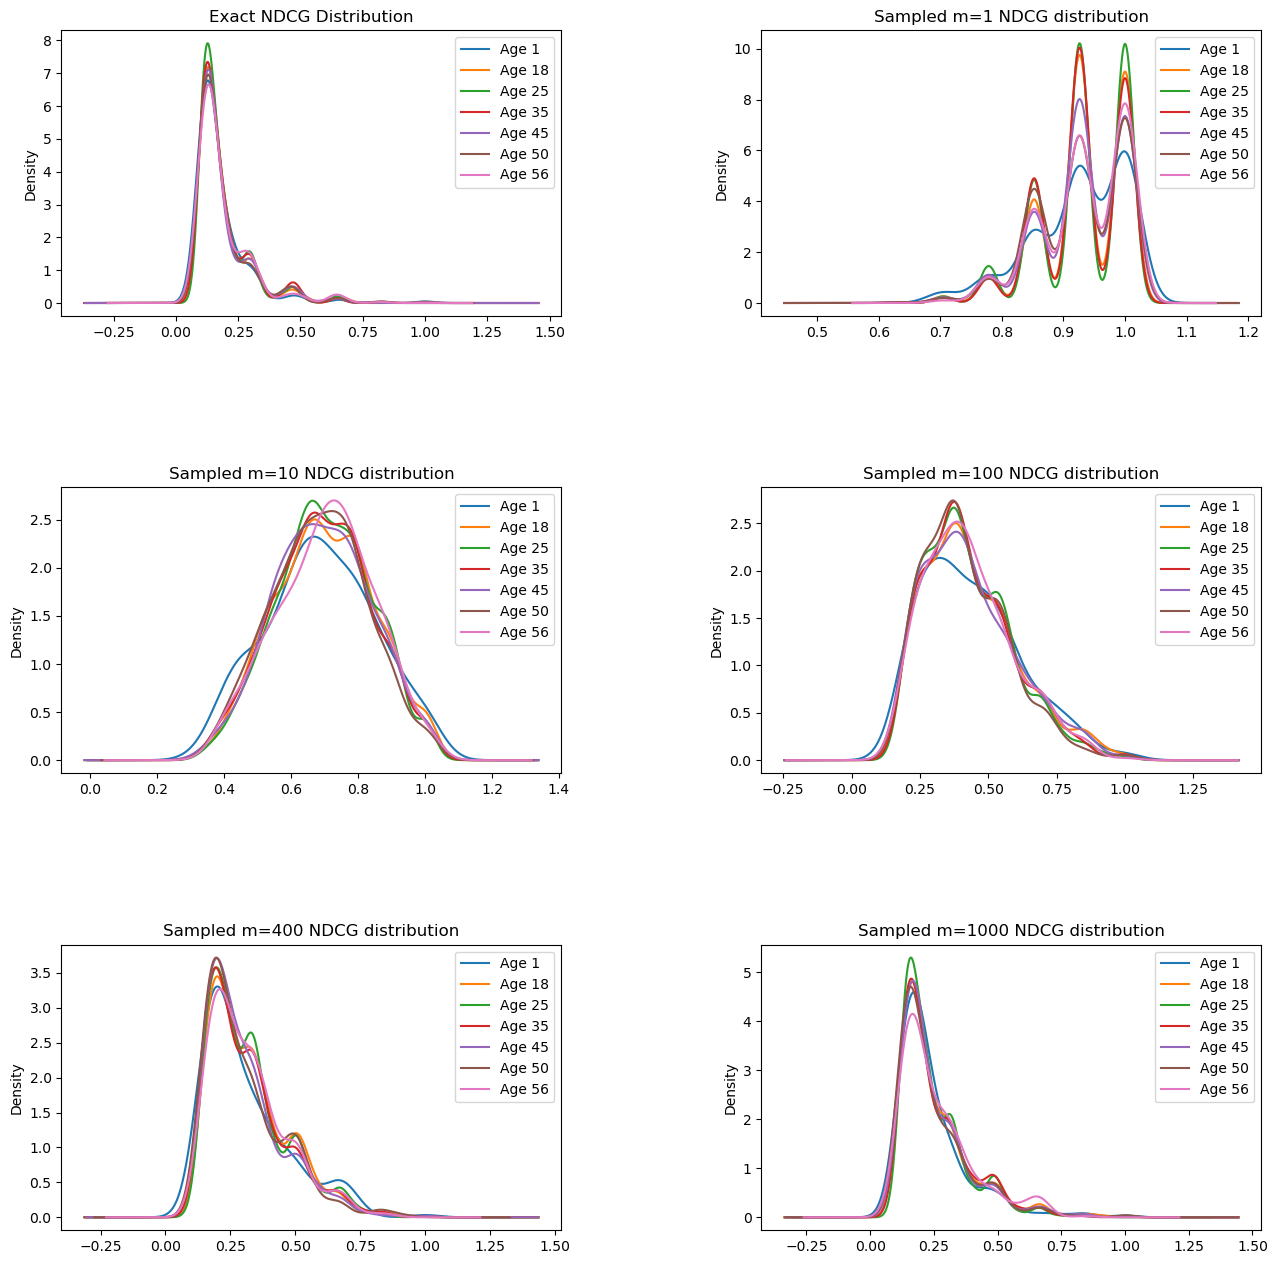

In [49]:
matplotlib.rc_file_defaults()
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
ndcgs = []
ndcg_df = pd.DataFrame()

for group_name, df_group in users_df.groupby('Age'):
    ndcgs = []
    print(f"Ranking {group_name}")
    user_df = mapped_df.loc[np.in1d(mapped_df.UserID, df_group.UserID), :]
    print("Ranking Exact Rankings")
    ndcg_df= pd.concat([ndcg_df, pd.DataFrame({f"Age {group_name}": ranking(n_rel=1, df=user_df)})], axis=1)
#     sns.distplot(ndcg_df.iloc[:, -1], hist=False, ax=ax[0, 0], label=f"Age {group_name}").set(title=f"Exact NDCG")
ndcg_df.plot.kde(ax=ax[0, 0])
ax[0, 0].title.set_text('Exact NDCG Distribution')
# n_ranking = len(ndcg_df["Exact"])
row = 0
col = 1
for i in [1, 10, 100, 400, 1000]:
    ndcg_df = pd.DataFrame()
    for group_name, df_group in users_df.groupby('Age'):
        print(f"Ranking with {i} sampled items on {group_name}")
#     ndcgs = np.pad(ndcgs, mode='constant')
        user_df = mapped_df.loc[np.in1d(mapped_df.UserID, df_group.UserID), :]
        ndcg_df = pd.concat([ndcg_df, pd.DataFrame({f"Age {group_name}": ranking(n_samples=i, df=user_df)})], axis=1)
        print()
#         sns.distplot(ndcg_df.iloc[:, -1], hist=False, ax=ax[row, col], label=f"Age {group_name}").set(title=f"NDCG of Sampled {i} items")
    ndcg_df.plot.kde(ax=ax[row, col])
    ax[row, col].title.set_text(f"Sampled m={i} NDCG distribution")
    col += 1
    if col %2  == 0:
        row += 1
        col = 0

plt.legend()
plt.show()

Ranking Exact Rankings


100%|██████████████████████████████████████████████████████████████| 6040/6040 [04:12<00:00, 23.90users/s]



Ranking with 1 sampled items


100%|█████████████████████████████████████████████████████████████| 6040/6040 [00:23<00:00, 257.88users/s]



Ranking with 10 sampled items


100%|█████████████████████████████████████████████████████████████| 6040/6040 [00:22<00:00, 270.72users/s]



Ranking with 40 sampled items


100%|█████████████████████████████████████████████████████████████| 6040/6040 [00:26<00:00, 225.41users/s]



Ranking with 100 sampled items


100%|█████████████████████████████████████████████████████████████| 6040/6040 [00:31<00:00, 190.66users/s]



Ranking with 400 sampled items


100%|█████████████████████████████████████████████████████████████| 6040/6040 [00:53<00:00, 113.34users/s]



Ranking with 1000 sampled items


100%|██████████████████████████████████████████████████████████████| 6040/6040 [01:34<00:00, 64.01users/s]


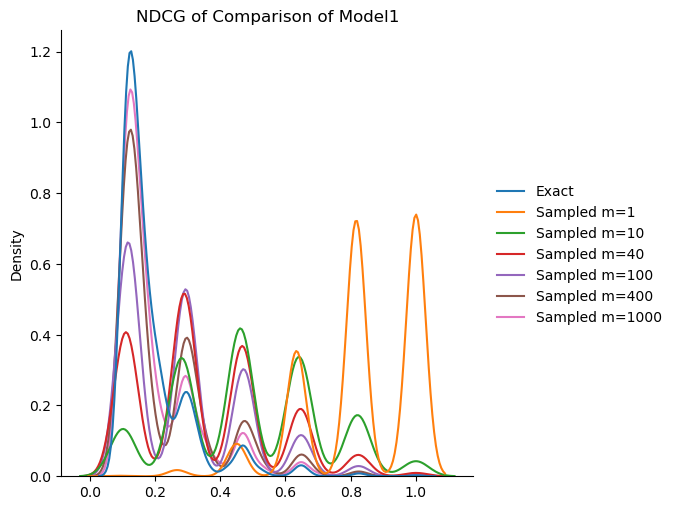

In [50]:
import seaborn as sns
ndcg_df = pd.DataFrame()
print("Ranking Exact Rankings")
ndcg_df["Exact"] = ranking(model=model1)
print()
# n_ranking = len(ndcg_df["Exact"])
for i in [1, 10, 40, 100, 400, 1000]:
    print(f"Ranking with {i} sampled items")
#     ndcgs = np.pad(ndcgs, mode='constant')
    ndcg_df[f"Sampled m={i}"] = ranking(n_samples=i, model=model1, correct=True)
    print()
sns.displot(ndcg_df, kind='kde').set(title="NDCG of Comparison of Model1")

In [51]:
import seaborn as sns
ndcg_df = pd.DataFrame()
print("Ranking Exact Rankings")
ndcg_df["Exact"] = rank_all(n_rel=5, model=model1)
print()
# n_ranking = len(ndcg_df["Exact"])
for i in [40, 100, 400, 1000]:
    print(f"Ranking with {i} sampled items")
#     ndcgs = np.pad(ndcgs, mode='constant')
    ndcg_df[f"Sampled m={i}"] = rank_samples(n_rel=5, n_samples=i, model=model1, correct=True)
    print()
sns.displot(ndcg_df, kind='kde').set(title="NDCG of Comparison of corrected 5 relevant items of model 1")

Ranking Exact Rankings


100%|██████████████████████████████████████████████████████████████| 6040/6040 [16:14<00:00,  6.20users/s]


Ranking with 40 sampled items


TypeError: rank_samples() missing 1 required positional argument: 'unique_users'